# MNIST Digit Classifier

This notebook builds and trains a convolutional neural network (CNN) to classify handwritten digits from the MNIST dataset.

## What is MNIST?

MNIST is a dataset containing 70,000 grayscale images of handwritten digits (0-9). Each image is 28x28 pixels. The dataset is split into 60,000 training images and 10,000 test images.

## What will we do in this notebook?

1. **Load and explore** the MNIST dataset
2. **Visualize** some example digits
3. **Build** a convolutional neural network (CNN)
4. **Train** the network on the training data
5. **Test** the network on previously unseen data
6. **Analyze** the model's performance by digit class

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

## Importing Libraries

Let's import the PyTorch libraries we'll need:

- **torch**: The main PyTorch library for tensor operations
- **torchvision**: Contains datasets, model architectures, and common image transformations
- **transforms**: Utility functions for preprocessing images

In [24]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define transformations to apply to the images
# 1. ToTensor: Converts PIL Image to PyTorch tensor and scales values to [0,1]
# 2. Normalize: Standardizes values using mean and std for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST standard mean and std
])

# Set batch size (number of images processed together)
batch_size = 4

# Load the training dataset
trainset = torchvision.datasets.MNIST(
    root='./data',          # Directory where data is stored/downloaded
    train=True,             # Use training split
    download=True,          # Download if not already on disk
    transform=transform     # Apply the transformations defined above
)

# Create training data loader to efficiently batch and shuffle data
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,  # Number of images in each batch
    shuffle=True,           # Randomize order of samples
    num_workers=0           # Number of subprocesses for data loading (0 = main process)
)

# Load the test dataset (same procedure but with train=False)
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,            # Use test split
    download=True,
    transform=transform
)

# Create test data loader (no need to shuffle test data)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

# Define class labels (digits 0-9)
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

print("Dataset loaded successfully!")
print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

Using device: cpu
Dataset loaded successfully!
Training samples: 60000
Test samples: 10000


## Loading and Preparing Data

This section loads the MNIST dataset and prepares it for training. We need to:

1. **Define the device** (CPU or GPU) to train on
2. **Set up transformations** to convert images to tensors and normalize them
3. **Create data loaders** that will feed data to our network during training

The **Normalize** transformation standardizes pixel values using the MNIST mean (0.1307) and standard deviation (0.3081), which helps neural networks train faster and better.

In [27]:
# MNIST dataset information
print(f"Type of trainset: {type(trainset)}")
print(f"Length of trainset (number of samples): {len(trainset)}")

# Get the shape of a single example
sample, label = trainset[0]
print(f"Shape of a single image: {sample.shape}")
print(f"Type of a single image: {type(sample)}")

# Dataset attributes
print(f"Available attributes of trainset: {dir(trainset)[:10]}...")

# Data dimensions
print(f"Input image dimensions: {sample.shape[1]}x{sample.shape[2]}")
print(f"Number of channels: {sample.shape[0]}")
print(f"Number of classes: {len(classes)}")

Type of trainset: <class 'torchvision.datasets.mnist.MNIST'>
Length of trainset (number of samples): 60000
Shape of a single image: torch.Size([1, 28, 28])
Type of a single image: <class 'torch.Tensor'>
Available attributes of trainset: ['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__']...
Input image dimensions: 28x28
Number of channels: 1
Number of classes: 10


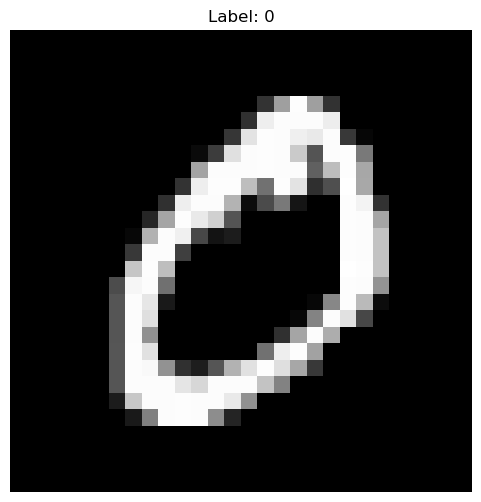

Image shape: torch.Size([1, 28, 28])
Label: 0


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize a single MNIST image (properly handle MNIST data structure)
try:
    
    image, label = trainset[1]
    
    # Convert from tensor to numpy and reshape for display
    # image shape is [1, 28, 28] - need to squeeze the channel dimension
    image_np = image.squeeze().numpy()
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()
    
    print(f"Image shape: {image.shape}")
    print(f"Label: {label}")
except Exception as e:
    print(f"Error displaying image: {e}")

First few samples in the dataset:

Sample 0:
  - Label: 5 (digit '5')
  - Image shape: torch.Size([1, 28, 28])
  - Min pixel value: -0.4242
  - Max pixel value: 2.8215

Sample 1:
  - Label: 0 (digit '0')
  - Image shape: torch.Size([1, 28, 28])
  - Min pixel value: -0.4242
  - Max pixel value: 2.8215

Sample 2:
  - Label: 4 (digit '4')
  - Image shape: torch.Size([1, 28, 28])
  - Min pixel value: -0.4242
  - Max pixel value: 2.8215

Sample 3:
  - Label: 1 (digit '1')
  - Image shape: torch.Size([1, 28, 28])
  - Min pixel value: -0.4242
  - Max pixel value: 2.8215


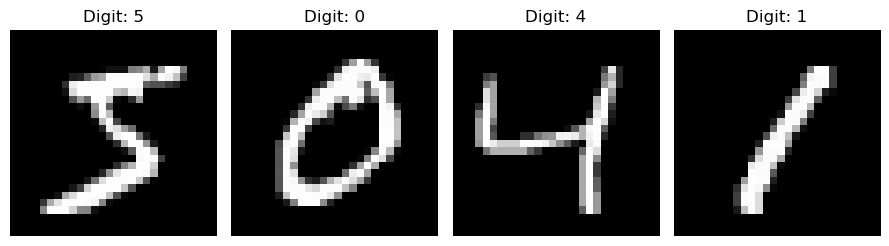

In [29]:
print("First few samples in the dataset:")

fig, axes = plt.subplots(1, 4, figsize=(9, 3))
for i in range(4):
    image, label = trainset[i]
    axes[i].imshow(image.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f"Digit: {label}")
    axes[i].axis('off')
    print(f"\nSample {i}:")
    print(f"  - Label: {label} (digit '{classes[label]}')")
    print(f"  - Image shape: {image.shape}")
    print(f"  - Min pixel value: {image.min().item():.4f}")
    print(f"  - Max pixel value: {image.max().item():.4f}")
plt.tight_layout()
plt.show()


## Convolutional Neural Network Architecture

Now we'll define our CNN model. Here's what each part does:

### Layers:
- **Convolutional layers (Conv2d)**: Extract features from the input images
- **Pooling layers (MaxPool2d)**: Reduce dimensions and extract dominant features
- **Fully connected layers (Linear)**: Make final predictions based on extracted features

### Activation Functions:
- **ReLU**: Adds non-linearity to allow the network to learn complex patterns

### Forward Pass:
The forward method defines the path data takes through the network, from input to output.

### CNN Structure:
1. Conv1 → ReLU → MaxPool
2. Conv2 → ReLU → MaxPool
3. Conv3 → ReLU → MaxPool
4. Flatten (convert 3D feature maps to 1D vector)
5. Three fully connected layers with ReLU between them


In [30]:
# Import necessary libraries for network definition
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        """Initialize the network layers"""
        super().__init__()
        
        # First convolutional layer
        # input channels=1 (grayscale), output channels=6, kernel size=5x5
        self.conv1 = nn.Conv2d(1, 6, 5)  # Input: 28x28x1 -> Output: 24x24x6
        
        # Second convolutional layer
        # input channels=6, output channels=16, kernel size=5x5
        self.conv2 = nn.Conv2d(6, 16, 5)  # Input: 12x12x6 -> Output: 8x8x16
        
        # Third convolutional layer
        # input channels=16, output channels=10, kernel size=5x5
        self.conv3 = nn.Conv2d(16, 10, 5)  # Input: 4x4x16 -> Output: 0x0x10 (this might cause issues)
        
        # Max pooling layer (used multiple times)
        # kernel size=2x2, stride=2
        self.pool = nn.MaxPool2d(2, 2)  # Reduces dimensions by half each time
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # This size must match the flattened output from conv layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output neurons for digits 0-9

    def forward(self, x):
        """Define the forward pass through the network"""
        # First block: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))  # 28x28x1 -> 24x24x6 -> 24x24x6 -> 12x12x6
        
        # Second block: Conv -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # 12x12x6 -> 8x8x16 -> 8x8x16 -> 4x4x16
        
        # Third block: Removing this due to dimension mismatch
        # x = self.pool(F.relu(self.conv3(x)))  # This would cause issues
        
        # Flatten all dimensions except batch (keep batch dim at position 0)
        x = torch.flatten(x, 1)  # 4x4x16 -> 256
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on output layer (will be handled by loss function)
        
        return x
        
# Create an instance of our network
net = Net()

# Move the network to the proper device (CPU or GPU)
net = net.to(device)

print("Neural network architecture:")
print(net)

Neural network architecture:
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loss Function and Optimizer

Before training, we need to define:

1. **Loss Function**: Measures how far our predictions are from the true values
   - For classification tasks like digit recognition, Cross Entropy Loss is commonly used
   - It combines softmax activation with negative log-likelihood loss

2. **Optimizer**: Updates the network weights to minimize the loss
   - SGD (Stochastic Gradient Descent) is a classic optimization algorithm
   - The learning rate (lr) controls how big each update step is
   - Momentum helps the optimizer escape local minima and converge faster

In [31]:
# Import the optimizer module
import torch.optim as optim

# Define the loss function (criterion)
# CrossEntropyLoss combines softmax and negative log-likelihood loss
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# SGD = Stochastic Gradient Descent
# Parameters:
#   - net.parameters(): all trainable parameters in the network
#   - lr=0.001: learning rate (controls step size)
#   - momentum=0.9: accelerates convergence and helps avoid local minima
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## Training the Network

Now we'll train our model using the training dataset. The training process follows these steps:

1. **Loop through epochs**: An epoch is one complete pass through the entire training dataset
2. **Loop through batches**: Process small batches of images at a time
3. **Forward pass**: Pass images through the network to get predictions
4. **Calculate loss**: Compare predictions to actual labels
5. **Backward pass**: Calculate gradients of the loss with respect to weights
6. **Update weights**: Use the optimizer to adjust the network's weights

This is the core of deep learning: the network gradually improves its predictions by adjusting weights based on errors.

In [32]:
# Number of complete passes through the training dataset
num_epochs = 2
print(f"Training for {num_epochs} epochs...")

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Loop over batches in the training data
    for i, data in enumerate(trainloader, 0):
        # Get the inputs and labels from the data loader
        inputs, labels = data
        
        # Move data to the right device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients (clear previous gradients)        
        optimizer.zero_grad()

        # Forward pass: compute predictions from inputs
        outputs = net(inputs)
        
        # Compute the loss between predictions and true labels
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()
        
        # Update model parameters using the optimizer
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] Loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training!')

Training for 2 epochs...
[Epoch 1, Batch   200] Loss: 2.264
[Epoch 1, Batch   400] Loss: 1.594
[Epoch 1, Batch   600] Loss: 0.762
[Epoch 1, Batch   800] Loss: 0.545
[Epoch 1, Batch  1000] Loss: 0.513
[Epoch 1, Batch  1200] Loss: 0.364
[Epoch 1, Batch  1400] Loss: 0.263
[Epoch 1, Batch  1600] Loss: 0.289
[Epoch 1, Batch  1800] Loss: 0.198
[Epoch 1, Batch  2000] Loss: 0.313
[Epoch 1, Batch  2200] Loss: 0.195
[Epoch 1, Batch  2400] Loss: 0.229
[Epoch 1, Batch  2600] Loss: 0.169
[Epoch 1, Batch  2800] Loss: 0.188
[Epoch 1, Batch  3000] Loss: 0.193
[Epoch 1, Batch  3200] Loss: 0.194
[Epoch 1, Batch  3400] Loss: 0.155
[Epoch 1, Batch  3600] Loss: 0.138
[Epoch 1, Batch  3800] Loss: 0.162
[Epoch 1, Batch  4000] Loss: 0.139
[Epoch 1, Batch  4200] Loss: 0.156
[Epoch 1, Batch  4400] Loss: 0.151
[Epoch 1, Batch  4600] Loss: 0.160
[Epoch 1, Batch  4800] Loss: 0.112
[Epoch 1, Batch  5000] Loss: 0.163
[Epoch 1, Batch  5200] Loss: 0.096
[Epoch 1, Batch  5400] Loss: 0.151
[Epoch 1, Batch  5600] Loss: 0

In [33]:
# Save the trained model with a more appropriate name
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)
print(f"Model saved to {PATH}")

Model saved to ./mnist_net.pth


test the model

# Testing the Model

Now that our model is trained, let's evaluate it on the test dataset. This helps us understand how well our model generalizes to new, unseen data.

We will:
1. Load a batch of test images
2. Display these images with their true labels
3. Run these images through our model to get predictions
4. Compare the predictions to the true labels

In a good model, most predictions should match the true labels. If they don't, the model might need more training data, a different architecture, or different hyperparameters.

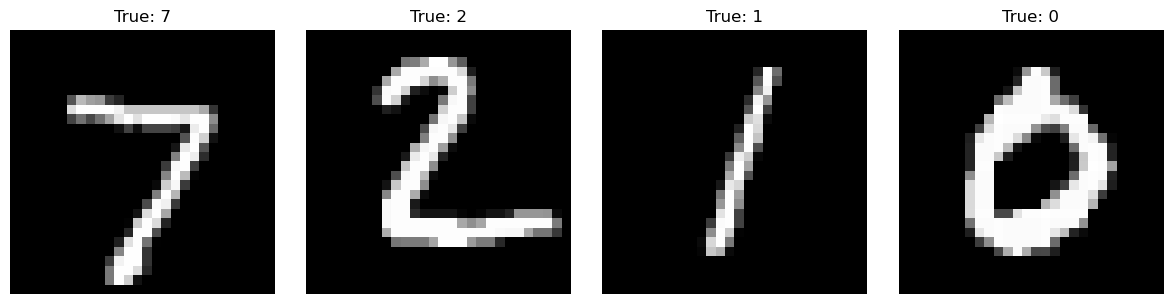

Ground Truth: 7 2 1 0


In [40]:
# Get a batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images to the right device (CPU or GPU)
images, labels = images.to(device), labels.to(device)

try:
    # Create a figure with subplots for each test image
    fig, axes = plt.subplots(1, batch_size, figsize=(12, 3))
    
    # Display each image in the batch
    for i in range(batch_size):
        # Move image back to CPU for matplotlib
        img = images[i].cpu()
        
        # Display in the appropriate subplot
        axes[i].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i].set_title(f"True: {classes[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print ground truth labels
    print('Ground Truth: ' + ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))
except Exception as e:
    print(f"Error displaying test images: {e}")

## Comprehensive Model Evaluation

Instead of testing the model multiple times, we'll define a single evaluation function that:

1. Runs through the entire test dataset once
2. Stores all predictions and true labels
3. Calculates all metrics (accuracy, per-class accuracy, precision, recall, F1-score)
4. Generates all visualizations (confusion matrix, accuracy bar chart)

This approach is more efficient as it avoids redundant computation and ensures consistency across all our metrics.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Define a comprehensive evaluation function
def evaluate_model(net, dataloader, device):

    # Initialize counters and storage
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    

    correct_pred = {classname: 0 for classname in classes}

    total_pred = {classname: 0 for classname in classes}
    

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            
           
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            
          
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            
            # Store all labels and predictions for further analysis
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    # Calculate overall accuracy
    accuracy = 100 * correct / total
    
    # Calculate per-class accuracy
    class_accuracy = {classname: 100 * correct_pred[classname] / total_pred[classname] 
                     for classname in classes}
    
    # Return all results for further analysis
    return {
        'accuracy': accuracy,
        'class_accuracy': class_accuracy,
        'correct_pred': correct_pred,
        'total_pred': total_pred,
        'y_true': np.array(all_labels),
        'y_pred': np.array(all_predictions)
    }

In [42]:
# Run the evaluation once and store all results
print("Running comprehensive model evaluation...")
results = evaluate_model(net, testloader, device)

# Print overall accuracy
print(f'Accuracy of the network on the 10000 test images: {results["accuracy"]:.2f}%')

Running comprehensive model evaluation...
Accuracy of the network on the 10000 test images: 98.69%
Accuracy of the network on the 10000 test images: 98.69%


### Per-Class Accuracy Accuracy

Let's visualize how well our model performs for each digit class. This helps identify specific digits that are more challenging for the model to recognize.


Accuracy for each digit:
-------------------------
Digit 0: 99.3% (973/980)
Digit 1: 99.8% (1133/1135)
Digit 2: 97.3% (1004/1032)
Digit 3: 98.6% (996/1010)
Digit 4: 99.2% (974/982)
Digit 5: 98.7% (880/892)
Digit 6: 98.3% (942/958)
Digit 7: 99.1% (1019/1028)
Digit 8: 98.5% (959/974)
Digit 9: 98.0% (989/1009)


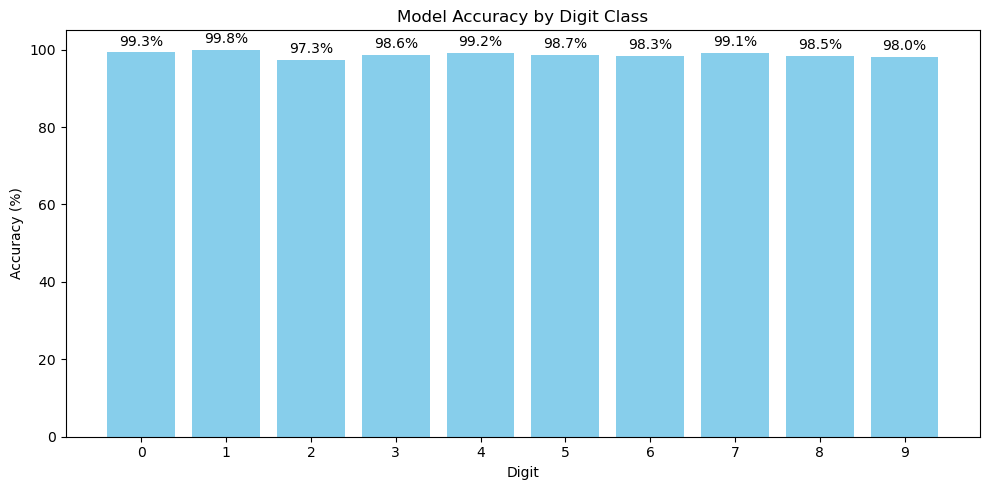


Most challenging digit: 2 with 97.3% accuracy


In [43]:
# Print per-class accuracy
print("\nAccuracy for each digit:")
print("-" * 25)

for classname, accuracy in results["class_accuracy"].items():
    correct = results["correct_pred"][classname]
    total = results["total_pred"][classname]
    print(f"Digit {classname}: {accuracy:.1f}% ({correct}/{total})")

# Create a bar chart of class accuracies
plt.figure(figsize=(10, 5))
digits = list(results["class_accuracy"].keys())
accuracies = list(results["class_accuracy"].values())

# Create bar chart
bars = plt.bar(digits, accuracies, color='skyblue')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom')

# Add labels and title
plt.xlabel('Digit')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy by Digit Class')
plt.ylim(0, 105)  # Set y-axis limits to accommodate the labels

# Show the plot
plt.tight_layout()
plt.show()

# Identify the most challenging digits
min_acc_digit = min(results["class_accuracy"], key=results["class_accuracy"].get)
print(f"\nMost challenging digit: {min_acc_digit} with {results['class_accuracy'][min_acc_digit]:.1f}% accuracy")

###  Precision, Recall, and F1 Score

Accuracy alone doesn't tell the complete story, especially for imbalanced datasets. Let's look at precision, recall, and F1 score for each class:

- **Precision**: How many of the predicted positives are actually correct? (TP / (TP + FP))
- **Recall**: How many of the actual positives did the model identify? (TP / (TP + FN))
- **F1 Score**: Harmonic mean of precision and recall, balancing both metrics

In [44]:
# Calculate precision, recall, and F1 score
precision = precision_score(results['y_true'], results['y_pred'], average=None)
recall = recall_score(results['y_true'], results['y_pred'], average=None)
f1 = f1_score(results['y_true'], results['y_pred'], average=None)

# Print metrics for each class
print("\nDetailed metrics by class:")
print("-" * 50)
print(f"{'Class':^10}{'Precision':^10}{'Recall':^10}{'F1 Score':^10}")
print("-" * 50)

for i, classname in enumerate(classes):
    print(f"{classname:^10}{precision[i]:.4f}{recall[i]:^10.4f}{f1[i]:^10.4f}")

# Overall metrics
print("\nOverall metrics:")
print(f"Average precision: {precision.mean():.4f}")
print(f"Average recall: {recall.mean():.4f}")
print(f"Average F1 score: {f1.mean():.4f}")


Detailed metrics by class:
--------------------------------------------------
  Class   Precision   Recall   F1 Score 
--------------------------------------------------
    0     0.9868  0.9929    0.9898  
    1     0.9742  0.9982    0.9861  
    2     0.9950  0.9729    0.9838  
    3     0.9901  0.9861    0.9881  
    4     0.9919  0.9919    0.9919  
    5     0.9789  0.9865    0.9827  
    6     0.9968  0.9833    0.9900  
    7     0.9845  0.9912    0.9879  
    8     0.9826  0.9846    0.9836  
    9     0.9900  0.9802    0.9851  

Overall metrics:
Average precision: 0.9871
Average recall: 0.9868
Average F1 score: 0.9869


### Visualizing Predictions on Sample Images

Let's visualize some predictions on sample images to get a better feel for how the model performs. We'll use the batch we extracted earlier and compare true labels with predicted ones.

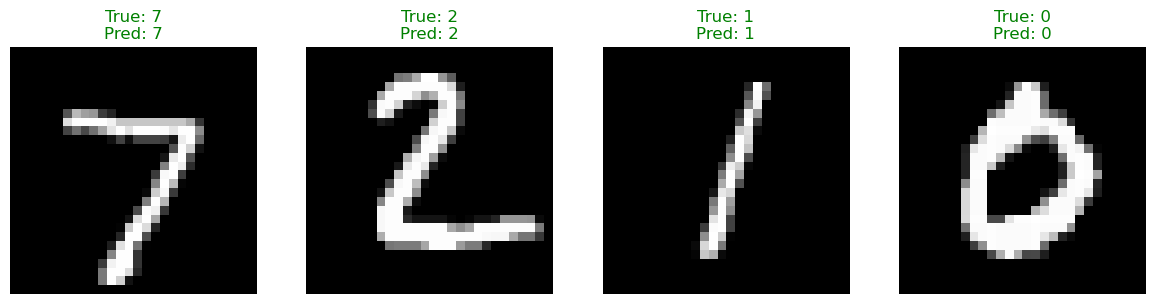

Ground Truth: 7     2     1     0    
Predicted:    7     2     1     0    
Accuracy on this batch: 100.0%


In [ ]:
# Get model predictions for the test images
with torch.no_grad():  # No need to track gradients for testing
    outputs = net(images)


_, predicted = torch.max(outputs, 1)


fig, axes = plt.subplots(1, batch_size, figsize=(12, 3))


for i in range(batch_size):

    img = images[i].cpu()
    
   
    true_label = classes[labels[i]]
    pred_label = classes[predicted[i]]
    
    
    title_color = 'green' if true_label == pred_label else 'red'
    
    
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


print('Ground Truth: ' + ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print('Predicted:    ' + ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

# Calculate accuracy for this batch
correct = (predicted == labels).sum().item()
print(f'Accuracy on this batch: {100 * correct / batch_size:.1f}%')

# Conclusion and Next Steps

Congratulations! You've successfully:
1. Loaded and visualized the MNIST dataset
2. Built a convolutional neural network with PyTorch
3. Trained the network on the training data
4. Evaluated the network on test data
5. Analyzed the model's performance by class

## Possible Improvements

To improve the model further, you could:

1. **Train for more epochs**: Let the model learn for longer
2. **Use data augmentation**: Create additional training examples by rotating, scaling, or adding noise to images
3. **Try different architectures**: Add or remove layers, change filter sizes, or use more modern CNN designs
4. **Adjust hyperparameters**: Modify learning rate, batch size, or regularization techniques
5. **Use transfer learning**: Start with a pre-trained model and fine-tune it for MNIST

## PyTorch Concepts Learned

- Tensors and tensor operations
- Dataset loading and transformation
- DataLoader for batch processing
- Neural network building with nn.Module
- Forward and backward passes
- Optimizers and loss functions
- Model evaluation techniques

The techniques you've learned here can be applied to more complex computer vision tasks!